In [33]:
import requests
import pandas as pd
import zipfile
import urllib
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from pathlib import Path
import cudf
import pickle
%load_ext autoreload
%autoreload
%load_ext cudf.pandas

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The cudf.pandas extension is already loaded. To reload it, use:
  %reload_ext cudf.pandas


In [33]:
date_range = pd.date_range(start='2023-01-01', end='2023-01-01')
csv_paths = [Path(f'data/AIS_{date.strftime("%Y_%m_%d")}.csv') for date in date_range]
daily_ais_dfs = [pd.read_csv(csv_path) for csv_path in csv_paths]
df = pd.concat(daily_ais_dfs)


### Assign Vessel Groups

In [11]:
vessel_groups = {}
vessel_groups["Cargo"] = np.concatenate([np.arange(70, 80), [1003, 1004, 1016]])
vessel_groups["Fishing"] = np.array([30, 1001, 1002])
vessel_groups["Military"] = np.array([35])
vessel_groups["Not Available"] = np.array([0])
vessel_groups["Other"] = np.concatenate([np.arange(1, 21), np.arange(23, 30), np.arange(33, 35), np.arange(38, 52), np.arange(53, 60), np.arange(90, 1000), np.arange(1005, 1012), [1018, 1020, 1022]])
vessel_groups["Passenger"] = np.concatenate([np.arange(60, 70), np.arange(1012, 1016)])
vessel_groups["Pleasure Craft"] = np.array([36, 37, 1019])
vessel_groups["Tanker"] = np.concatenate([np.arange(80, 90), [1017, 1024]])
vessel_groups["Tug Tow"] = np.array([21, 22, 31, 32, 52, 1023, 1025])

def assign_vessel_group(df):
    map_to_vessel_group = dict()
    
    for vg in vessel_groups:
        for i in vessel_groups[vg]:
            map_to_vessel_group[int(i)] = vg
    vessel_group_to_id = dict()
    for i, v in enumerate(set(map_to_vessel_group.values())):
        vessel_group_to_id[v] = i
        
    df["Vessel Group"] = df["VesselType"].map(map_to_vessel_group)
        
    
    

In [4]:
assign_vessel_group(df)
df.head()

NameError: name 'df' is not defined

In [50]:
df.tail()

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo,TransceiverClass,Vessel Group,LAT_bin,LON_bin
7474972,211785580,2023-02-01T22:27:44,13.26399,144.66774,0.1,360.0,511.0,COQUELICOT,IMO0000000,DJ6693,36.0,NaN,13.0,4.0,NaN,NaN,B,Pleasure Craft,12.78,<NA>
7474973,211785580,2023-02-01T22:36:44,13.26395,144.66774,0.3,360.0,511.0,COQUELICOT,IMO0000000,DJ6693,36.0,NaN,13.0,4.0,NaN,NaN,B,Pleasure Craft,12.78,<NA>
7474974,211785580,2023-02-01T23:30:44,13.26418,144.66770,0.2,360.0,511.0,COQUELICOT,IMO0000000,DJ6693,36.0,NaN,13.0,4.0,NaN,NaN,B,Pleasure Craft,12.78,<NA>
7474975,211785580,2023-02-01T23:39:47,13.26416,144.66772,0.5,350.7,511.0,COQUELICOT,IMO0000000,DJ6693,36.0,NaN,13.0,4.0,NaN,NaN,B,Pleasure Craft,12.78,<NA>
7474976,211785580,2023-02-01T23:42:47,13.26417,144.66771,0.5,5.3,511.0,COQUELICOT,IMO0000000,DJ6693,36.0,NaN,13.0,4.0,NaN,NaN,B,Pleasure Craft,12.78,<NA>


In [59]:
heatmap_unique_MMSI = df.groupby(['LAT_bin'])
heatmap_unique_MMSI = df.groupby(['LAT_bin', 'LON_bin'])['MMSI'].nunique().unstack().fillna(0)
# heatmap_unique_MMSI.first()
heatmap_unique_MMSI.head()

,45.35,46.90,46.12,47.67,33.71,34.49,38.37,43.80,44.57,48.45,...,18.20,22.08,14.33,15.10,15.88,16.65,18.98,13.55,41.47,42.24
LAT_bin,,,,,,,,,,,,,,,,,,,,,
13.55,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14.33,1.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15.10,1.0,4.0,1.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15.88,3.0,5.0,9.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16.65,17.0,7.0,12.0,1.0,0.0,1.0,0.0,0.0,13.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Positional Heatmaps

In [70]:
import warnings

# Suppress all warnings from the cudf library
warnings.filterwarnings('ignore', category=UserWarning, module='cudf')
warnings.filterwarnings('ignore', category=FutureWarning, module='cudf')

## Define the bins for the lat and lon
LON_min = -130
LON_max = -60
LAT_min = 12
LAT_max = 50

LAT_bins = np.linspace(LAT_min, LAT_max, 50)
LON_bins = np.linspace(LON_min, LON_max, 50)

## Define total date range to iterate
start_date = pd.to_datetime('2023-01-01')
end_date = pd.to_datetime('2023-12-31')

## Split into months
date_range = pd.date_range(start=start_date, end=end_date, freq='M')

## Vessel heatmaps
vessel_group_msg_heatmaps = dict()
vessel_group_msg_heatmaps = {key: None for key in vessel_groups}

vessel_group_unique_MMSI_heatmaps = dict()
vessel_group_unique_MMSI_heatmaps = {key: None for key in vessel_groups}

print(vessel_group_msg_heatmaps)

for month in tqdm(date_range, desc="Processing Months"):
    print()
    print(f"Processing Month: {month}")
    # create monthly dfs
    start_of_month = month.strftime('%Y-%m-01')
    # end_of_month = month.strftime('%Y-%m-%d')
    end_of_month = month.strftime('%Y-%m-01')
    
    # print(f"Start Date: {start_of_month}, End Date: {end_of_month}")
    
    monthly_date_range = pd.date_range(start=start_of_month, end=end_of_month, freq='D')
    csv_paths = [Path(f'data/AIS_{date.strftime("%Y_%m_%d")}.csv') for date in monthly_date_range]
    
    daily_ais_dfs = [pd.read_csv(csv_path) for csv_path in csv_paths]
    df = pd.concat(daily_ais_dfs)
    assign_vessel_group(df)
    
    # Sort into bins for this month
    df["LAT_bin"] = pd.cut(df["LAT"], bins=LAT_bins, labels=np.round(LAT_bins[:-1],decimals=2))
    df["LON_bin"] = pd.cut(df["LON"], bins=LON_bins, labels=np.round(LAT_bins[:-1],decimals=2))
    
    # # Create a pivot table to aggregate the counts of lat and lon bins
    # heatmap_data = df.pivot_table(index='LAT_bin', columns='LON_bin', aggfunc='size', fill_value=0)
    # heatmap_data = heatmap_data.iloc[::-1]
    # print(heatmap_data)
    
    for vessel_group in tqdm(vessel_groups, desc="Processing Vessel Groups"):
        # print("Processing Vessel Group: ", vessel_group)
        vessel_group_df = df[df["Vessel Group"] == vessel_group]
        
        heatmap_msg_data = vessel_group_df.pivot_table(index='LAT_bin', columns='LON_bin', aggfunc='size', fill_value=0)
        heatmap_msg_data = heatmap_msg_data.iloc[::-1]

        
        # heatmap_unique_MMSI = vessel_group_df.groupby(['LAT_bin', 'LON_bin'])['MMSI'].nunique().unstack().fillna(0)
        # heatmap_unique_MMSI = heatmap_unique_MMSI.iloc[::-1]
        
        
        # print(heatmap_msg_data)
        # print(heatmap_unique_MMSI)
        # print("---------------")

        
        if vessel_group_msg_heatmaps[vessel_group] is None:
            vessel_group_msg_heatmaps[vessel_group] = heatmap_msg_data.copy()
            
        else:
            vessel_group_msg_heatmaps[vessel_group] += heatmap_msg_data.copy()
            
        # if vessel_group_unique_MMSI_heatmaps[vessel_group] is None:
        #     vessel_group_unique_MMSI_heatmaps[vessel_group] = heatmap_unique_MMSI.copy()
        # else:
        #     vessel_group_unique_MMSI_heatmaps[vessel_group] += heatmap_unique_MMSI.copy()



# Specify the file path to save the pickle file
pickle_file_path = 'vessel_group_msg_heatmaps.pkl'

# Save the variable to the pickle file
with open(pickle_file_path, 'wb') as file:
    pickle.dump(vessel_group_msg_heatmaps, file)

{'Cargo': None, 'Fishing': None, 'Military': None, 'Not Available': None, 'Other': None, 'Passenger': None, 'Pleasure Craft': None, 'Tanker': None, 'Tug Tow': None}


Processing Months:   0%|          | 0/12 [00:00<?, ?it/s]

Processing Month: 2023-01-31 00:00:00


Processing Months:   8%|▊         | 1/12 [00:03<00:38,  3.50s/it]


Processing Month: 2023-02-28 00:00:00


Processing Months:  17%|█▋        | 2/12 [00:06<00:34,  3.45s/it]


Processing Month: 2023-03-31 00:00:00


Processing Months:  25%|██▌       | 3/12 [00:10<00:31,  3.54s/it]


Processing Month: 2023-04-30 00:00:00


Processing Months:  33%|███▎      | 4/12 [00:14<00:29,  3.70s/it]


Processing Month: 2023-05-31 00:00:00


Processing Months:  42%|████▏     | 5/12 [00:18<00:26,  3.84s/it]


Processing Month: 2023-06-30 00:00:00


Processing Months:  50%|█████     | 6/12 [00:22<00:23,  3.97s/it]


Processing Month: 2023-07-31 00:00:00


Processing Months:  58%|█████▊    | 7/12 [00:27<00:20,  4.15s/it]


Processing Month: 2023-08-31 00:00:00


Processing Months:  58%|█████▊    | 7/12 [00:31<00:22,  4.48s/it]


KeyboardInterrupt: 

In [38]:
print(vessel_group_msg_heatmaps)

{'Cargo':          12.00  12.78  13.55  14.33  15.10  15.88  16.65  17.43  18.20  18.98  \
LAT_bin                                                                         
49.22        0      6     48     79  29487      0      0      0      0      0   
48.45        4     92   9271   6128  44341   2614      0      0      0      0   
47.67        0     23   2246   5431  18106   4274      0      0      0      0   
46.90       26     59    699   2125   1342  21021      0      0      0      0   
46.12      273    482   1065   7699   9231      0      0      0      0      0   
45.35       99     10    308   2021   8276  16393      0      0      0      0   
44.57      391      7    155   1524      0      0      0      0      0      0   
43.80      107     52    399   1676      0      0      0      0      0      0   
43.02      196      0    996   2229   1316      0      0      0      0      0   
42.24      284      0    938   1515      0      0      0      0      0      0   
41.47      554    

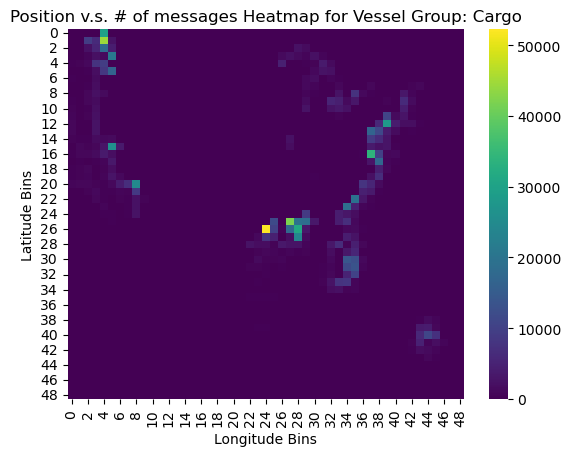

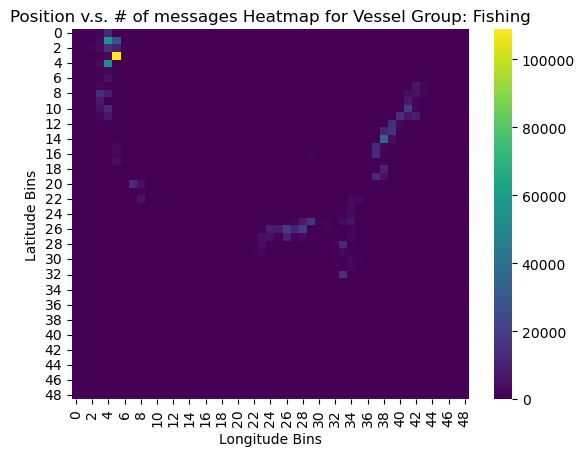

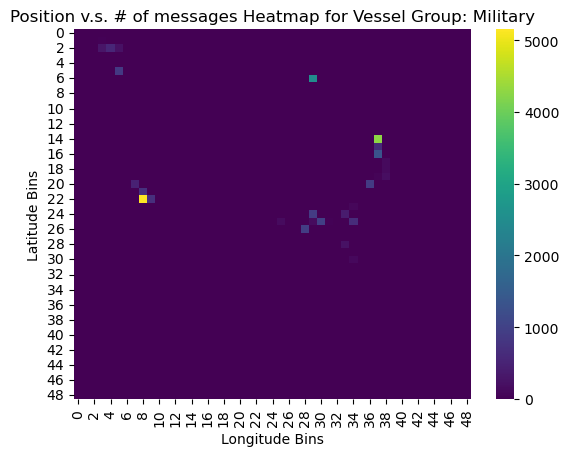

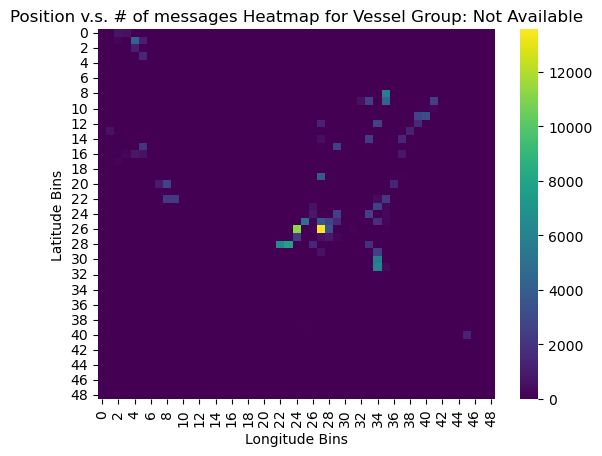

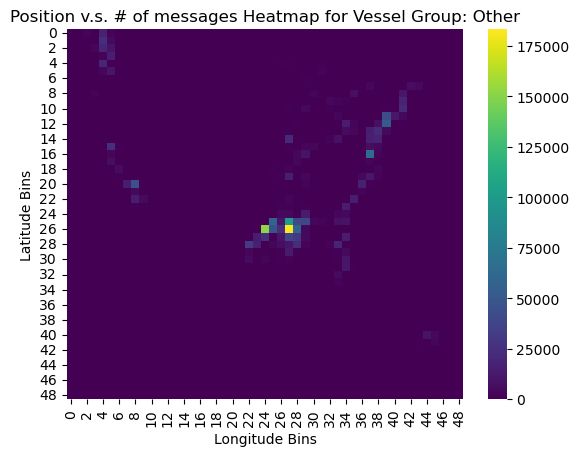

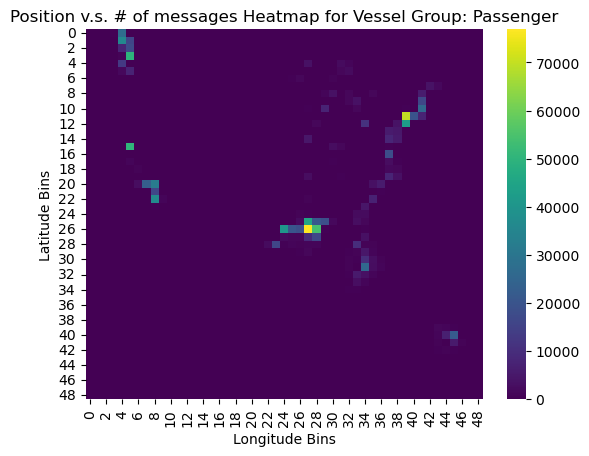

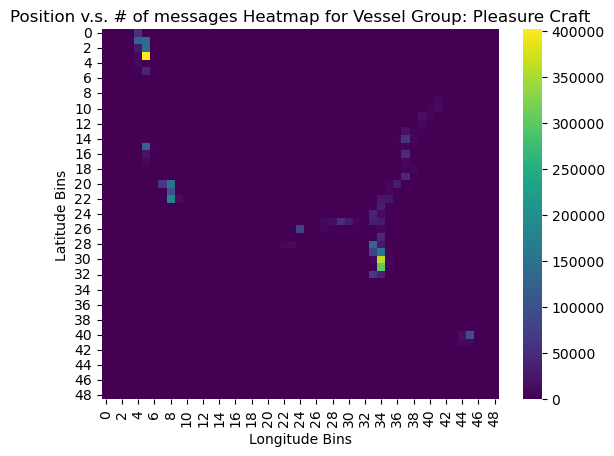

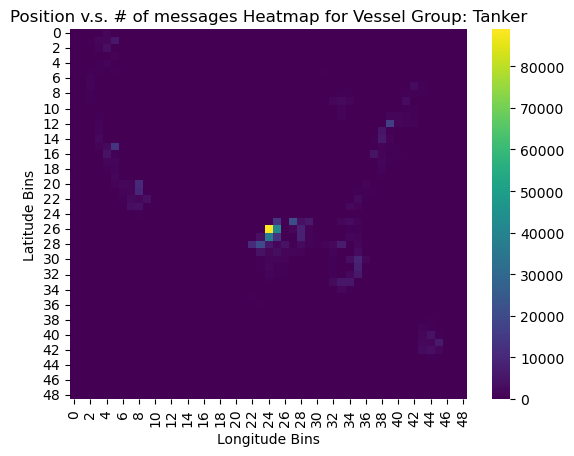

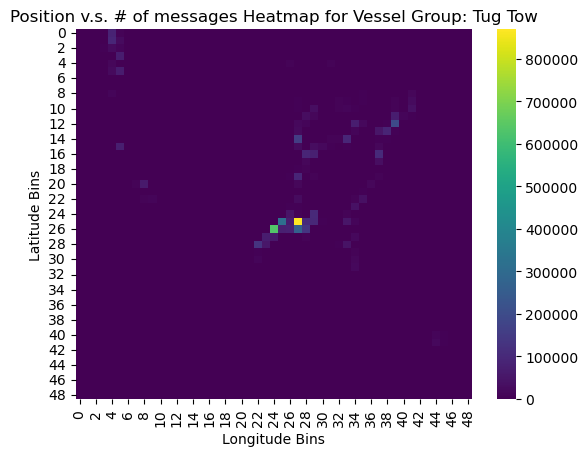

In [62]:

for vg, hm in vessel_group_msg_heatmaps.items():
    sns_plt = sns.heatmap(hm, cmap='viridis')

    # Set the axis labels and title
    plt.xlabel('Longitude Bins')
    plt.ylabel('Latitude Bins')
    plt.title(f'Position v.s. # of messages Heatmap for Vessel Group: {vg}')
    plt.show()  

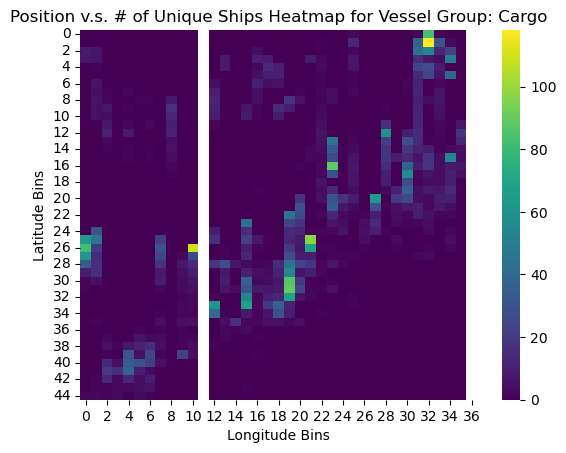

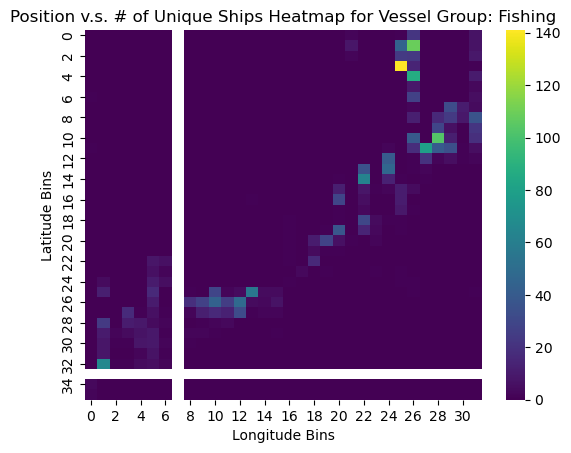

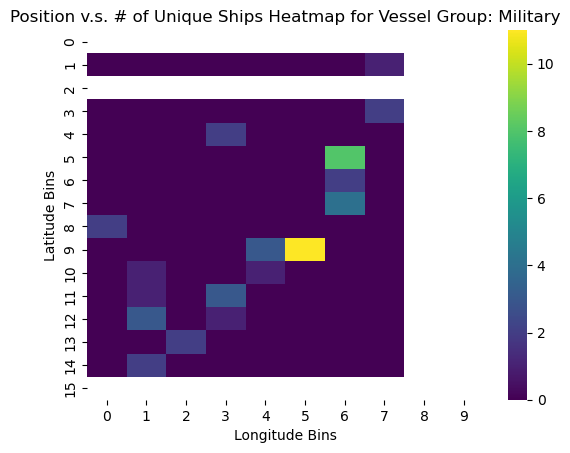

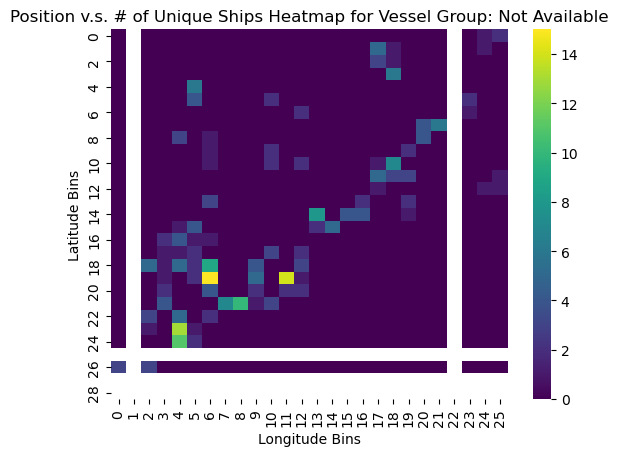

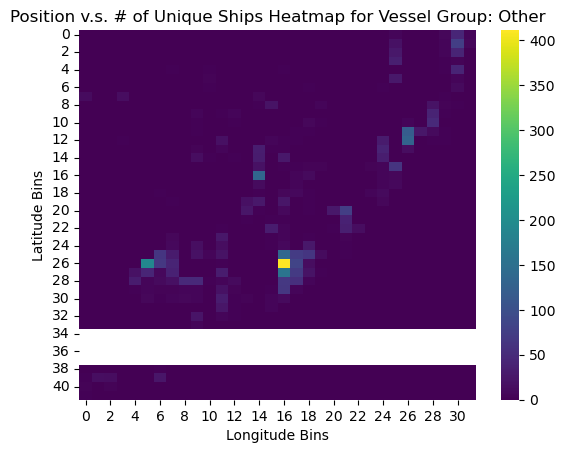

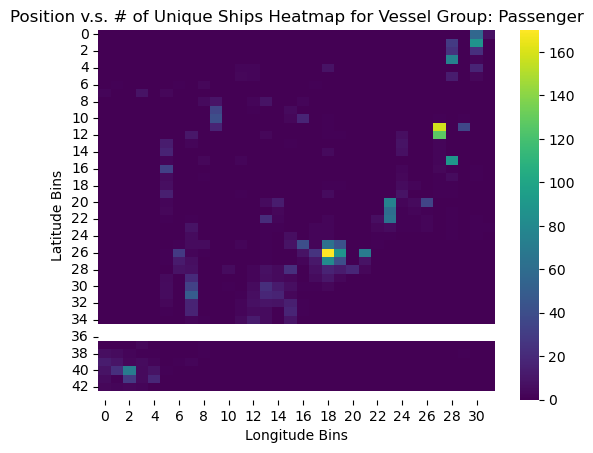

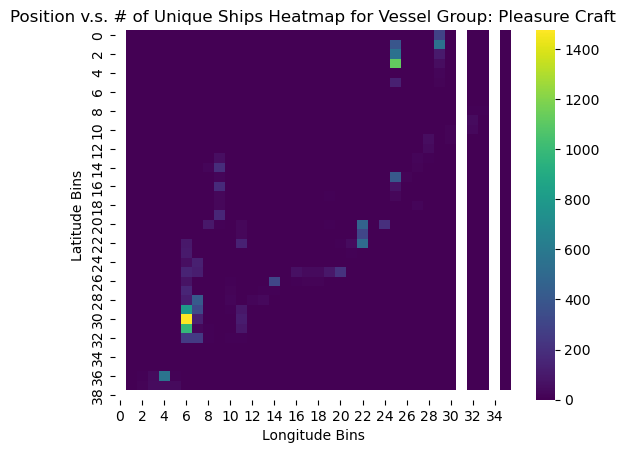

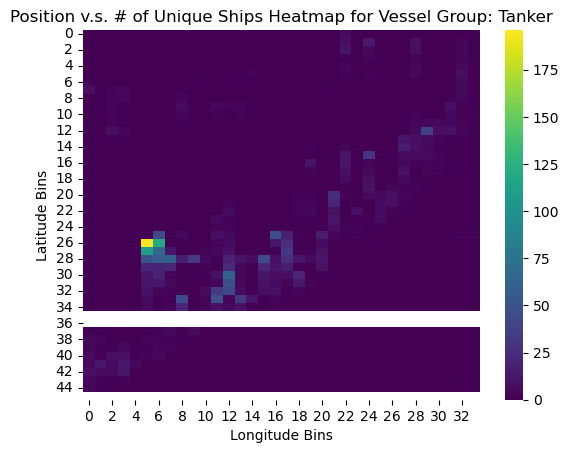

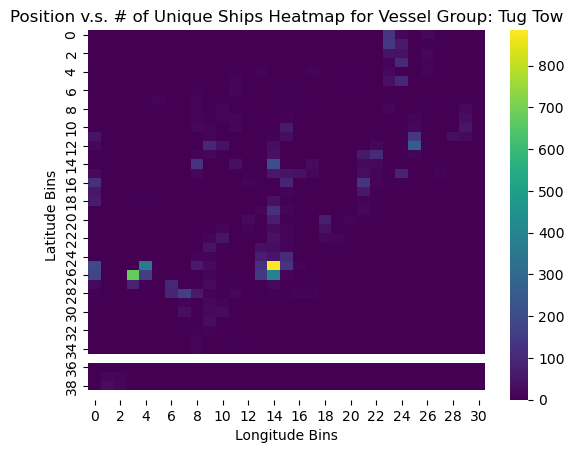

In [63]:

for vg, hm in vessel_group_unique_MMSI_heatmaps.items():
    sns_plt = sns.heatmap(hm, cmap='viridis')

    # Set the axis labels and title
    plt.xlabel('Longitude Bins')
    plt.ylabel('Latitude Bins')
    plt.title(f'Position v.s. # of Unique Ships Heatmap for Vessel Group: {vg}')
    plt.show()  

/home/workstation4/anaconda3/envs/AIS/lib/python3.12/site-packages/cudf/pandas/fast_slow_proxy.py:26: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  return fn(*args, **kwargs)


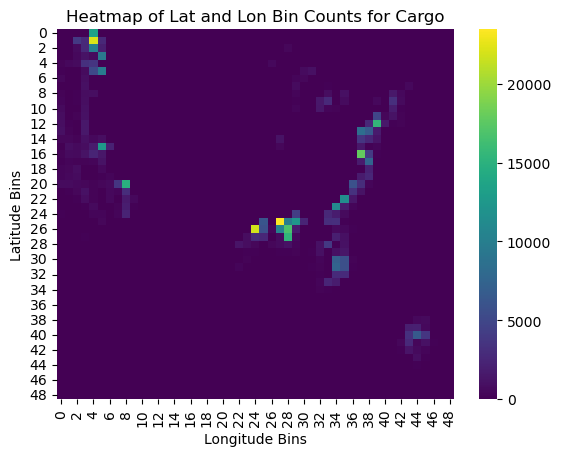

/home/workstation4/anaconda3/envs/AIS/lib/python3.12/site-packages/cudf/pandas/fast_slow_proxy.py:26: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  return fn(*args, **kwargs)


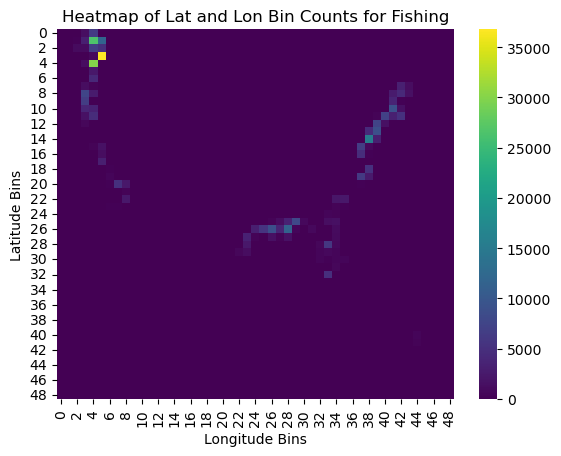

/home/workstation4/anaconda3/envs/AIS/lib/python3.12/site-packages/cudf/pandas/fast_slow_proxy.py:26: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  return fn(*args, **kwargs)


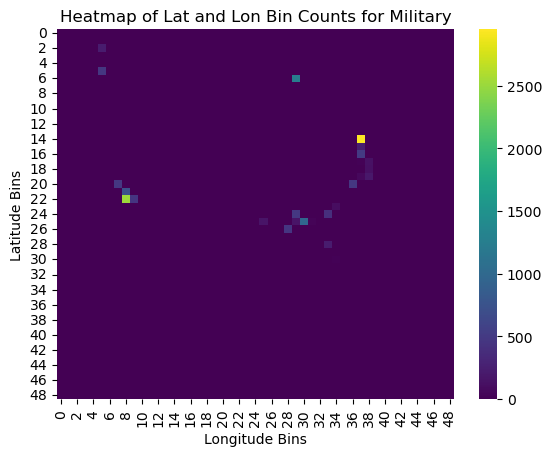

/home/workstation4/anaconda3/envs/AIS/lib/python3.12/site-packages/cudf/pandas/fast_slow_proxy.py:26: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  return fn(*args, **kwargs)


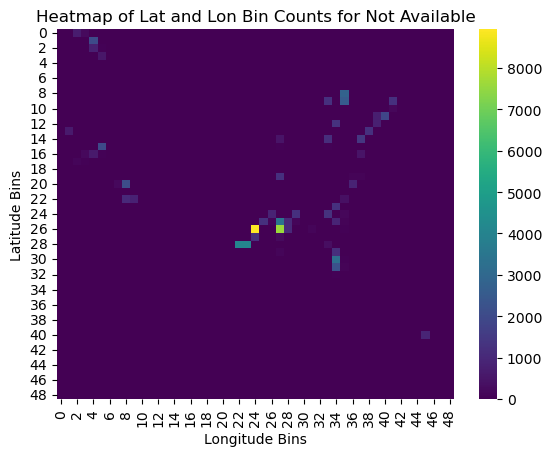

/home/workstation4/anaconda3/envs/AIS/lib/python3.12/site-packages/cudf/pandas/fast_slow_proxy.py:26: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  return fn(*args, **kwargs)


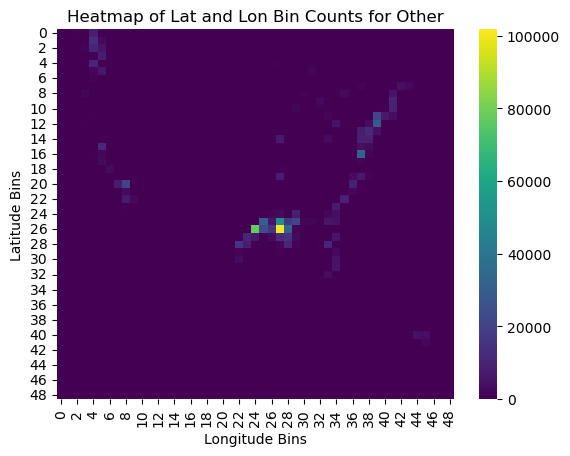

/home/workstation4/anaconda3/envs/AIS/lib/python3.12/site-packages/cudf/pandas/fast_slow_proxy.py:26: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  return fn(*args, **kwargs)


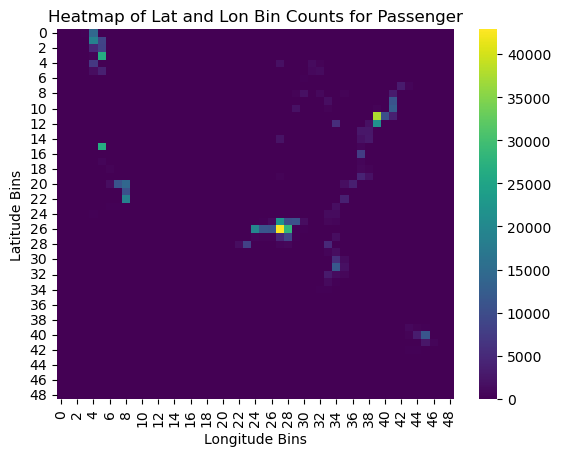

/home/workstation4/anaconda3/envs/AIS/lib/python3.12/site-packages/cudf/pandas/fast_slow_proxy.py:26: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  return fn(*args, **kwargs)


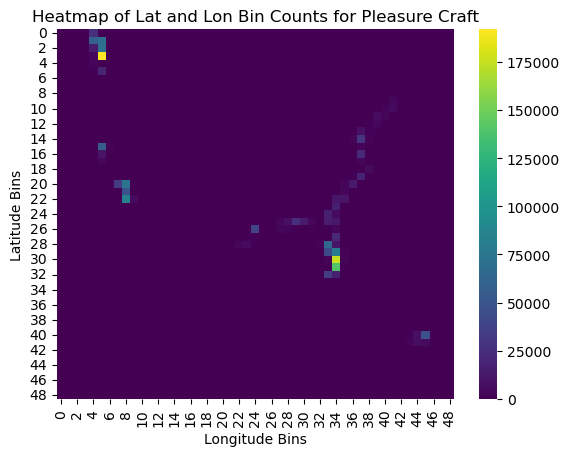

/home/workstation4/anaconda3/envs/AIS/lib/python3.12/site-packages/cudf/pandas/fast_slow_proxy.py:26: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  return fn(*args, **kwargs)


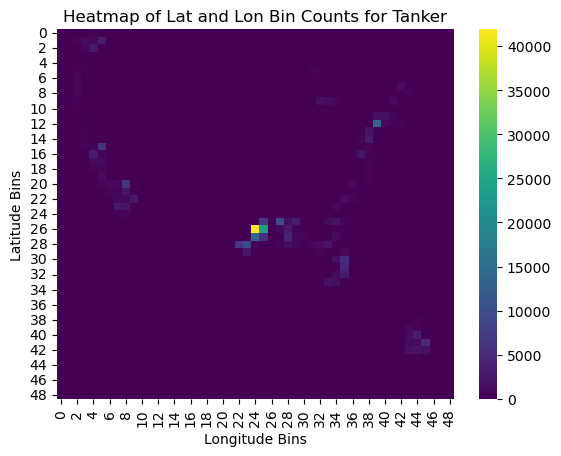

/home/workstation4/anaconda3/envs/AIS/lib/python3.12/site-packages/cudf/pandas/fast_slow_proxy.py:26: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  return fn(*args, **kwargs)


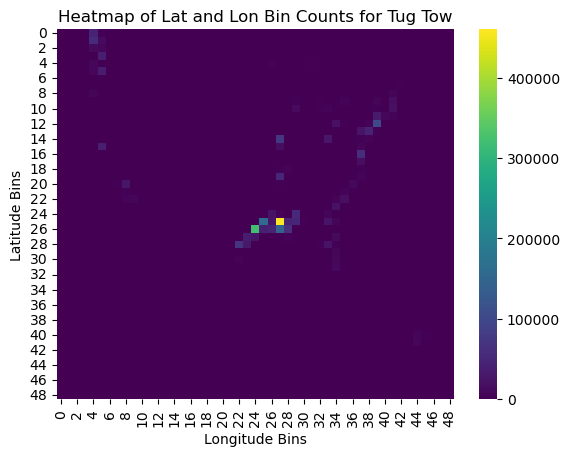

In [17]:
LON_min = -130
LON_max = -60
LAT_min = 12
LAT_max = 50

LAT_bins = np.linspace(LAT_min, LAT_max, 50)
LON_bins = np.linspace(LON_min, LON_max, 50)

df["LAT_bin"] = pd.cut(df["LAT"], bins=LAT_bins, labels=np.round(LAT_bins[:-1],decimals=2))
df["LON_bin"] = pd.cut(df["LON"], bins=LON_bins, labels=np.round(LAT_bins[:-1],decimals=2))

# Create a pivot table to aggregate the counts of lat and lon bins
# heatmap_data = df.pivot_table(index='LAT_bin', columns='LON_bin', aggfunc='size', fill_value=0)
# heatmap_data = heatmap_data.iloc[::-1]
# heatmap_data.head()

# Create the heatmap
# sns.heatmap(heatmap_data, cmap='viridis')

# # Set the axis labels and title
# plt.xlabel('Longitude Bins')
# plt.ylabel('Latitude Bins')
# plt.title('Heatmap of Lat and Lon Bin Counts')

for vessel in vessel_groups:
    vessel_df = df[df["Vessel Group"] == vessel]
    heatmap_msg_data = vessel_df.pivot_table(index='LAT_bin', columns='LON_bin', aggfunc='size', fill_value=0)
    heatmap_msg_data = heatmap_msg_data.iloc[::-1]
    # Create the heatmap
    sns_plt = sns.heatmap(heatmap_msg_data, cmap='viridis')

    # Set the axis labels and title
    plt.xlabel('Longitude Bins')
    plt.ylabel('Latitude Bins')
    plt.title(f'Heatmap of Lat and Lon Bin Counts for {vessel}')
    plt.show()  
    
    fig = sns_plt.get_figure()
    fig.savefig("")
# Show the heatmap
plt.show()

### Timestep Distribution

In [101]:
unique_MMSIs = df['MMSI'].unique()
dt = [] # Store the time deltas

# Iterate through uids (MMSI) to compute time deltas
# for MMSI in unique_MMSIs:
#     MMSI_df = df[df['MMSI'] == MMSI]
df.sort_values(by=['BaseDateTime'], inplace=True)
df['BaseDateTime'] = pd.to_datetime(df['BaseDateTime'])
df['TimeDelta'] = df.groupby('MMSI')['BaseDateTime'].diff()

In [102]:
df.tail()
df[df['MMSI']==367357320]

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo,TransceiverClass,TimeDelta
7579,367357320,2023-01-01 00:00:09,30.80223,-81.51778,0.0,360.0,511.0,C-TRACTOR 3,IMO8835164,WBX3589,70.0,0.0,29.0,11.0,3.3,31.0,A,NaT
10048,367357320,2023-01-01 00:01:20,30.80223,-81.51778,0.0,360.0,511.0,C-TRACTOR 3,IMO8835164,WBX3589,70.0,0.0,29.0,11.0,3.3,31.0,A,0 days 00:01:11
16641,367357320,2023-01-01 00:02:28,30.80222,-81.51778,0.0,360.0,511.0,C-TRACTOR 3,IMO8835164,WBX3589,70.0,0.0,29.0,11.0,3.3,31.0,A,0 days 00:01:08
25369,367357320,2023-01-01 00:03:39,30.80221,-81.51778,0.0,360.0,511.0,C-TRACTOR 3,IMO8835164,WBX3589,70.0,0.0,29.0,11.0,3.3,31.0,A,0 days 00:01:11
64153,367357320,2023-01-01 00:04:59,30.80221,-81.51778,0.0,360.0,511.0,C-TRACTOR 3,IMO8835164,WBX3589,70.0,0.0,29.0,11.0,3.3,31.0,A,0 days 00:01:20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8144212,367357320,2023-01-01 23:55:19,30.80221,-81.51777,0.0,360.0,511.0,C-TRACTOR 3,IMO8835164,WBX3589,70.0,0.0,29.0,11.0,3.3,31.0,A,0 days 00:01:10
7418498,367357320,2023-01-01 23:56:28,30.80222,-81.51777,0.0,360.0,511.0,C-TRACTOR 3,IMO8835164,WBX3589,70.0,0.0,29.0,11.0,3.3,31.0,A,0 days 00:01:09
7418470,367357320,2023-01-01 23:57:40,30.80222,-81.51779,0.0,360.0,511.0,C-TRACTOR 3,IMO8835164,WBX3589,70.0,0.0,29.0,11.0,3.3,31.0,A,0 days 00:01:12
8146923,367357320,2023-01-01 23:58:50,30.80222,-81.51780,0.0,360.0,511.0,C-TRACTOR 3,IMO8835164,WBX3589,70.0,0.0,29.0,11.0,3.3,31.0,A,0 days 00:01:10


In [103]:
df['TimeDelta'].dt.total_seconds().max()

np.float64(85041.0)

(1, 2000)

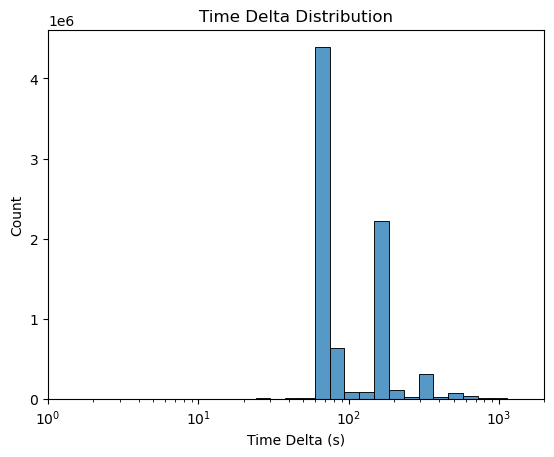

In [104]:
ax = sns.histplot(df['TimeDelta'].dt.total_seconds(), bins=50, log_scale=True)
ax.set(xlabel='Time Delta (s)', ylabel='Count', title='Time Delta Distribution')
ax.set_xlim(1, 2000)

### Positional Heatmaps based on Vessel Type

In [29]:

# sns.histplot(data=df, x='LON', y='LAT', cmap='viridis')
# plt.title('LAT vs LON Heatmap')
# plt.show()

df['VesselType'].unique()


### Distribution of Vessel Types

MMSI: 100%|██████████| 15932/15932 [03:04<00:00, 86.24it/s]


Text(0.5, 0, 'Count')

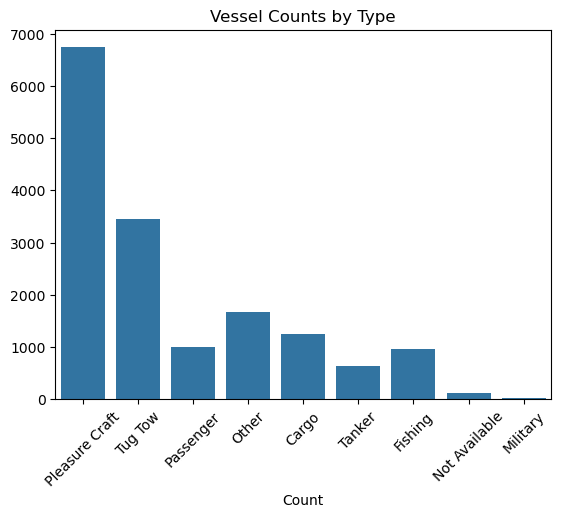

In [108]:

vessel_groups_counts = {}

# Assign vessel groups to each MMSI



unique_MMSIs = df['MMSI'].unique()
for MMSI in tqdm(unique_MMSIs, desc='MMSI'):
     MMSI_df = df[df['MMSI'] == MMSI]
     vessel_type = MMSI_df.iloc[0]['VesselType']

     for vessel_group in vessel_groups:
          if vessel_type in vessel_groups[vessel_group]:
               df.loc[df['MMSI'] == MMSI,'VesselGroup'] = vessel_group # update the DataFrame with the vessel group
               if vessel_group in vessel_groups_counts:
                    vessel_groups_counts[vessel_group] += 1
               else:
                    vessel_groups_counts[vessel_group] = 1

sns.barplot(vessel_groups_counts)
plt.title("Vessel Counts by Type")
plt.xticks(rotation=45)
plt.xlabel('Count')

In [90]:
df.head()

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo,TransceiverClass,TimeDelta,VesselGroup
2351,366876420,2023-01-01,32.72374,-117.22354,0.0,18.7,511.0,AFTERGLOW,NaN,WDI5149,37.0,NaN,33.0,8.0,NaN,NaN,B,NaT,Pleasure Craft
682,366989380,2023-01-01,38.06354,-122.26807,36.2,248.4,248.0,MARE ISLAND,IMO9144665,WDC2198,60.0,0.0,43.0,12.0,1.5,60.0,A,NaT,Passenger
7346,367486370,2023-01-01,33.74594,-118.22476,0.0,218.2,8.0,NRC QUEST,IMO9271195,WDF7619,90.0,0.0,48.0,10.0,3.0,70.0,A,NaT,Other
673,368122350,2023-01-01,21.28582,-157.86644,5.6,275.4,511.0,TIGER22-,NaN,WDL3512,99.0,0.0,0.0,0.0,0.0,99.0,A,NaT,Other
3425,368045410,2023-01-01,27.84012,-97.06920,0.0,140.5,511.0,JOSEPH F WEBER,IMO1012865430,WDK3453,60.0,15.0,46.0,16.0,3.3,60.0,A,NaT,Passenger


### SOG v.s. Vessel Type

Unique Vessel Types: 66


<Axes: xlabel='SOG', ylabel='VesselGroup'>

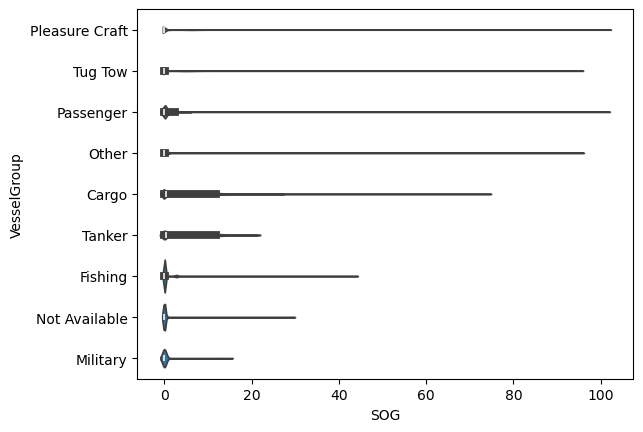

In [113]:
# Remove sentinel SOG values
# 102.3: Not available
# 102.2: 102.2 knots or higher
df_SOG = df[(df['SOG'] != 102.3) & (df['SOG'] != 102.2)]
unique_vessel_types = df_SOG['VesselType'].unique()
unique_vessel_types.sort()
print(f'Unique Vessel Types: {len(unique_vessel_types)}')

max_SOG_by_vessel_type = {}

df_SOG.tail()
sns.violinplot(data=df_SOG, x="SOG", y="VesselGroup")

# sns.boxplot(data=df_SOG, x="SOG", y="VesselGroup", whis=(0,100))
